# Download and set up libraries

Install pennylane

In [69]:
# !pip install pennylane 
# !pip install  matplotlib
# !pip install pennylane
# !pip install numpy
# !pip install torch torchvision torchaudio
# !pip install scikit-learn
# !pip install nltk
# !pip install gensim
# !pip install seaborn


Import Libraries

In [70]:
import torch
import pennylane as qml
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
import os
import matplotlib.pyplot as plt # type: ignore
from sklearn import datasets # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import time
import keras # type: ignore
#define load_model
from tensorflow import keras
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from nltk.corpus import treebank
from gensim.models import KeyedVectors
import nltk
# Ensure you have the necessary NLTK data
nltk.download('treebank')
nltk.download('universal_tagset')


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\minhd\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\minhd\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [71]:
# Get cpu, gpu or mps device for training.
device = (
    # "cuda"
    # if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    # else "cpu"
    "cpu"
)
print(f"Using {device} device")

Using cpu device


In [72]:
print("pennylane version: ", qml.__version__)
print("torch version: ", torch.__version__)

pennylane version:  0.33.1
torch version:  2.3.0+cu118


# Build quantum layers

Quantum Convolutional 1D layer class

In [73]:
class QuantumConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_of_quantum_layer=1,dev='default.qubit'):
        super(QuantumConv1D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_of_quantum_layer = num_of_quantum_layer
        self.num_qubits=in_channels*kernel_size
        self.dev = qml.device(dev,wires=self.num_qubits)

        # Initialize the quantum weights
        self.weight = nn.Parameter(torch.randn((out_channels, self.num_qubits), requires_grad=True))

        # Define the quantum circuit
        @qml.qnode(self.dev)
        def quantum_circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(self.num_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(self.num_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.num_qubits)]
        
        self.qlayer = qml.QNode(quantum_circuit, self.dev, interface='torch')
        self.weight_shapes = {"weights": (self.num_of_quantum_layer, self.num_qubits)}
        self.c_layer_in=torch.nn.Linear(self.num_qubits,self.num_qubits)
        self.VQC = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.c_layer_out=torch.nn.Linear(self.num_qubits,self.num_qubits)

    def forward(self, x):
        batch_size, in_channels, width = x.shape
        out_width = width - self.kernel_size + 1
        output = torch.zeros((batch_size, self.out_channels, out_width))
        def quan_func(b,i):
            input_patch = x[b, :, i:i+self.kernel_size].flatten()
            input_temp = self.c_layer_in(input_patch)
            input_temp = self.VQC(input_temp)
            input_temp = self.c_layer_out(input_temp)
            return torch.sum(input_temp, axis=0)
        for b in range(batch_size):
            for i in range(out_width):
                output[b, :, i] = quan_func(b,i)
        return output

Quantum Convolutional 2D layer class

In [115]:
class QuantumConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_of_quantum_layer=1, dev='default.qubit'):
        super(QuantumConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_qubits = kernel_size**2 * in_channels
        self.dev = qml.device(dev, wires=self.num_qubits)
        self.num_of_quantum_layer = num_of_quantum_layer

        # Initialize the quantum weights
        self.weight = nn.Parameter(torch.randn((out_channels, self.num_qubits), requires_grad=True))

    

    def forward(self, x):
        @qml.qnode(self.dev)
        def quantum_circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(self.num_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(self.num_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.num_qubits)]

        qlayer = qml.QNode(quantum_circuit, self.dev, interface='torch')
        weight_shapes = {"weights": (self.num_of_quantum_layer, self.num_qubits)}
        c_layer_in=torch.nn.Linear(self.num_qubits,self.num_qubits)
        VQC = qml.qnn.TorchLayer(qlayer, weight_shapes)
        c_layer_out=torch.nn.Linear(self.num_qubits,self.num_qubits)
        batch_size, in_channels, height, width = x.shape
        out_height = height - self.kernel_size + 1
        out_width = width - self.kernel_size + 1
        output = torch.zeros((batch_size, self.out_channels, out_height, out_width))
        def quan_func(b,i,j):
            input_patch = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size].flatten()
            input_temp = c_layer_in(input_patch)
            input_temp = VQC(input_temp)
            input_temp = c_layer_out(input_temp)
            return torch.sum(input_temp, axis=0)
        for b in range(batch_size):
            for i in range(out_height):
                for j in range(out_width):
                    output[b, :, i, j] = quan_func(b,i,j)
        return output

Quantum Convolutional 3D layer class

In [75]:
class QuantumConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_of_quantum_layer=1, dev='default.qubit'):
        super(QuantumConv3D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_qubits = kernel_size**3 * in_channels
        self.dev = qml.device(dev, wires=self.num_qubits)
        self.num_of_quantum_layer = num_of_quantum_layer

        # Initialize the quantum weights
        self.weight = nn.Parameter(torch.randn((out_channels, self.num_qubits), requires_grad=True))

        # Define the quantum circuit
        @qml.qnode(self.dev)
        def quantum_circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(self.num_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(self.num_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.num_qubits)]

        self.qlayer = qml.QNode(quantum_circuit, self.dev, interface='torch')
        self.weight_shapes = {"weights": (self.num_of_quantum_layer, self.num_qubits)}
        self.c_layer_in=torch.nn.Linear(self.num_qubits,self.num_qubits)
        self.VQC = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.c_layer_out=torch.nn.Linear(self.num_qubits,self.num_qubits)

    def forward(self, x):
        batch_size, in_channels, depth, height, width = x.shape
        out_depth = depth - self.kernel_size + 1
        out_height = height - self.kernel_size + 1
        out_width = width - self.kernel_size + 1
        output = torch.zeros((batch_size, self.out_channels, out_depth, out_height, out_width))
        def quan_func(b,i,j,k):
            input_patch = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size, k:k+self.kernel_size].flatten()
            input_temp = self.c_layer_in(input_patch)
            input_temp = self.VQC(input_temp)
            input_temp = self.c_layer_out(input_temp)
            return torch.sum(input_temp, axis=0)
        for b in range(batch_size):
            for i in range(out_depth):
                for j in range(out_height):
                    for k in range(out_width):
                        output[b, :, i, j, k] = quan_func(b,i,j,k)
        return output

Quantum Dense layer class

In [76]:
class QuantumLinear(nn.Module):
    def __init__(self,in_features,out_features,bias=True,dev='default.qubit',num_of_quantum_layer=1):
        super(QuantumLinear,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = qml.device(dev,wires=self.in_features)
        self.number_of_layers = num_of_quantum_layer
        self.num_qubits = self.in_features

        #initialize the weights
        self.weights = torch.nn.Parameter(torch.randn(self.num_qubits*self.number_of_layers))
        self.bias = torch.nn.Parameter(torch.randn(self.out_features))

        #define the quantum circuit
        @qml.qnode(self.device,interface='torch')
        def quantum_circuit(inputs,weights):
            #load the input data
            qml.templates.AngleEmbedding(inputs,wires=range(self.num_qubits))
            #load the weights
            qml.templates.BasicEntanglerLayers(weights,wires=range(self.num_qubits))
            #return the expectation value of the Z operator
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.num_qubits)]
        
        self.qlayer=qml.QNode(quantum_circuit,self.device,interface='torch')
        self.weight_shapes = {"weights":(self.number_of_layers,self.num_qubits)}
        self.c_layer_in=nn.Linear(self.num_qubits,self.num_qubits)
        self.VQC=qml.qnn.TorchLayer(self.qlayer,weight_shapes=self.weight_shapes)
        self.c_layer_out=nn.Linear(self.num_qubits,self.out_features)

    def forward(self,x):
        x=self.c_layer_in(x)
        x=self.VQC(x)
        x=self.c_layer_out(x)
        return x

Quantum LSTM layer class

In [77]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                number_of_quantum_layer=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                device="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.number_of_quantum_layer = number_of_quantum_layer
        self.device = device  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.device, wires=self.wires_forget)
        self.dev_input = qml.device(self.device, wires=self.wires_input)
        self.dev_update = qml.device(self.device, wires=self.wires_update)
        self.dev_output = qml.device(self.device, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (number_of_quantum_layer, n_qubits)}
        print(f"weight_shapes = (number_of_quantum_layer, n_qubits) = ({number_of_quantum_layer}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  
            c_t = torch.zeros(batch_size, self.hidden_size)  
        else:
        
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
           
            x_t = x[:, t, :]
            
       
            v_t = torch.cat((h_t, x_t), dim=1)

      
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

# Test model

## Set up parameters

In [125]:
# conv1d
number_of_conv1d_samples = 4
number_of_conv1d_epochs = 2
conv1d_split_ratio = 0.2
number_of_conv1d_batch_size = 1
# conv2d
number_of_conv2d_samples = 4
number_of_conv2d_epochs = 2
conv2d_split_ratio = 0.2
number_of_conv2d_classes=2
number_of_conv2d_batch_size = 1

# dense
number_of_dense_samples = 200
number_of_dense_epochs = 3
dense_split_ratio = 0.2
number_of_dense_batch_size = 5

#lstm
number_of_lstm_batch_size = 2
number_of_lstm_samples = 2
number_of_lstm_epochs = 2
lstm_split_ratio = 0.2

# transfer learning
number_of_transfer_learning_samples = 4
number_of_transfer_learning_epochs = 2
transfer_learning_split_ratio = 0.2
number_of_transfer_learning_classes = 2
number_of_transfer_learning_batch_size = 1

# quantization
number_of_quantization_samples = number_of_conv2d_samples
number_of_quantization_epochs = number_of_conv2d_epochs
quantization_split_ratio = conv2d_split_ratio
number_of_quantization_classes = number_of_conv2d_classes
number_of_quantization_batch_size = number_of_conv2d_batch_size



## Test quantum models and compare with classical models

### 1D Convolution

Define train and test function

In [79]:
# Define the training loop
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Define the testing loop
def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred.squeeze(), y)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Test Error: \n Avg loss: {avg_loss:>8f} \n")
    return avg_loss

#compute avg absolute mean error on train and test data 
def avg_absolute_mean_error(model, dataloader):
    mae=0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            mae = mae+torch.mean(torch.abs(pred.squeeze()-y)).item()
    mae = mae/len(dataloader)
    print(f"MAE: {mae:>8f}")
    print("\n")


Load The Boston Housing Prices dataset and preprocess data

In [80]:
#Load The Boston Housing Prices dataset and preprocess data
boston_housing = tf.keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()


# Normalize the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
# take only 150 samples
train_data = train_data[:number_of_conv1d_samples]
train_labels = train_labels[:number_of_conv1d_samples]
test_data = test_data[:number_of_conv1d_samples]
test_labels = test_labels[:number_of_conv1d_samples]
#convert train_data to shape (batch_size, in_channels, width)
train_data = train_data.reshape(-1, 1, 13)
test_data = test_data.reshape(-1, 1, 13)
print(f"Data shape: {train_data.shape}")
print(f"Labels shape: {train_labels.shape}")

# load to train and test dataloader
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

boston_train_loader = DataLoader(dataset=train_dataset, batch_size=number_of_conv1d_batch_size, shuffle=True)
boston_test_loader = DataLoader(dataset=test_dataset, batch_size=number_of_conv1d_batch_size, shuffle=False)

Data shape: (4, 1, 13)
Labels shape: (4,)


Classical model

In [81]:
#initialize the model
class ClassicalConv1DNetwork(nn.Module):
    def __init__(self):
        super(ClassicalConv1DNetwork, self).__init__()
        self.conv1 = nn.Conv1d(1,3,3)
        self.conv2 = nn.Conv1d(3,6,3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(54, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
classical_conv1d_model = ClassicalConv1DNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(classical_conv1d_model.parameters(), lr=1e-3)
epochs = number_of_conv1d_epochs
classical_conv1d_train_losses=[]
classical_conv1d_test_losses=[]
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(boston_train_loader, classical_conv1d_model, loss_fn, optimizer)
    classical_conv1d_train_losses.append(train_loss)
    test_loss = test(boston_test_loader, classical_conv1d_model, loss_fn)
    classical_conv1d_test_losses.append(test_loss)
end_time = time.time()
classical_conv1d_time = end_time-start_time
print("Training Time: ", classical_conv1d_time)

Epoch 1
-------------------------------
Test Error: 
 Avg loss: 355.863450 

Epoch 2
-------------------------------
Test Error: 
 Avg loss: 355.212234 

Training Time:  0.03261566162109375


In [82]:
#compute avg absolute mean error on train and test data
print("Train data")
avg_absolute_mean_error(classical_conv1d_model, boston_train_loader)
print("Test data")
avg_absolute_mean_error(classical_conv1d_model, boston_test_loader)

Train data
MAE: 31.671067


Test data
MAE: 17.452014




Quantum model

In [83]:
# Define the model
class QuantumConv1DNetwork(nn.Module):
    def __init__(self):
        super(QuantumConv1DNetwork, self).__init__()
        self.conv1 = QuantumConv1D(1, 3, 3)
        self.conv2 = QuantumConv1D(3, 6, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(54, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
quantum_conv1d_model = QuantumConv1DNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(quantum_conv1d_model.parameters(), lr=1e-3)
epochs = number_of_conv1d_epochs
quantum_conv1d_train_losses = []
quantum_conv1d_test_losses = []

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    quantum_conv1d_train_losses.append(train(boston_train_loader, quantum_conv1d_model, loss_fn, optimizer))
    quantum_conv1d_test_losses.append(test(boston_test_loader, quantum_conv1d_model, loss_fn))
end_time = time.time()
quantum_conv1d_time = end_time-start_time
print("Training Time: ", quantum_conv1d_time)

Epoch 1
-------------------------------
Test Error: 
 Avg loss: 373.651076 

Epoch 2
-------------------------------
Test Error: 
 Avg loss: 369.368145 

Training Time:  6.715039491653442


In [84]:
#compute avg absolute mean error on train and test data
print("Train data")
avg_absolute_mean_error(quantum_conv1d_model, boston_train_loader)
print("Test data")
avg_absolute_mean_error(quantum_conv1d_model, boston_test_loader)

Train data
MAE: 32.006917


Test data
MAE: 17.869810




Compare

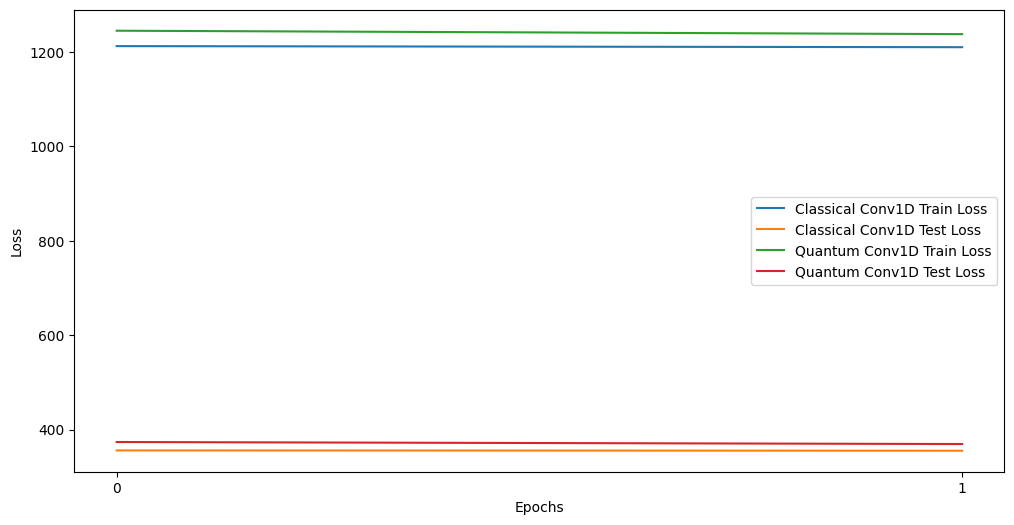

In [85]:
#plot loss through epochs for classical and quantum model
plt.figure(figsize=(12, 6))
plt.plot(classical_conv1d_train_losses, label="Classical Conv1D Train Loss")
plt.plot(classical_conv1d_test_losses, label="Classical Conv1D Test Loss")
plt.plot(quantum_conv1d_train_losses, label="Quantum Conv1D Train Loss")
plt.plot(quantum_conv1d_test_losses, label="Quantum Conv1D Test Loss")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Loss")
plt.legend()
plt.show()



### 2D Convolution

Define train and test function

In [117]:
def train(data_loader,model,loss_fn,optimizer):
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % number_of_conv2d_batch_size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(data_loader,model,loss_fn):
    size = len(data_loader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss


Load MNIST dataset and preprocess data

In [118]:
# Load the MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



classes = [i for i in range(number_of_conv2d_classes)]

train_images = train_images[np.isin(train_labels, classes)]
train_labels = train_labels[np.isin(train_labels, classes)]
test_images = test_images[np.isin(test_labels, classes)]
test_labels = test_labels[np.isin(test_labels, classes)]
number_sample_train=int(number_of_conv2d_samples*(1-conv2d_split_ratio))
number_sample_test=number_of_conv2d_samples-number_sample_train

train_images = train_images[:number_sample_train]
test_images = test_images[:number_sample_test]
train_labels = train_labels[:number_sample_train]
test_labels = test_labels[:number_sample_test]


print(f"Train data shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
#convert (batch, height, width, channels) to (batch, channels, height, width)
train_images = np.transpose(train_images, (0,3,1,2))
test_images = np.transpose(test_images, (0,3,1,2))

#convert the data to torch tensors
X_train_tensor = torch.tensor(train_images).float()
y_train_tensor = torch.tensor(train_labels).long()
X_test_tensor = torch.tensor(test_images).float()
y_test_tensor = torch.tensor(test_labels).long()

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

mnist_train_dataloader = torch.utils.data.DataLoader(
    list(zip(X_train_tensor, y_train_tensor)), batch_size=number_of_conv2d_batch_size, shuffle=True
)

mnist_test_dataloader = torch.utils.data.DataLoader(
    list(zip(X_test_tensor, y_test_tensor)), batch_size=number_of_conv2d_batch_size, shuffle=True
)

Train data shape: (3, 28, 28)
Train labels shape: (3,)
Test data shape: (1, 28, 28)
Test labels shape: (1,)
torch.Size([3, 1, 28, 28])
torch.Size([3])
torch.Size([1, 1, 28, 28])
torch.Size([1])


Classical model

In [88]:
class ClassicalConv2DNetwork(nn.Module):
    def __init__(self):
        super(ClassicalConv2DNetwork,self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*13*13, 100)
        self.fc2 = nn.Linear(100, number_of_conv2d_classes)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
classical_conv2d_model = ClassicalConv2DNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classical_conv2d_model.parameters(), lr=1e-3)

epochs = number_of_conv2d_epochs
classical_conv2d_losses=[]
classical_conv2d_accuracies=[]
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(mnist_train_dataloader, classical_conv2d_model, loss_fn, optimizer)
    correct,loss = test(mnist_test_dataloader, classical_conv2d_model, loss_fn)
    classical_conv2d_losses.append(loss)
    classical_conv2d_accuracies.append(correct)
end_time = time.time()
classical_conv2d_time = end_time-start_time
print("Training Time: ", classical_conv2d_time)



Epoch 1
-------------------------------
loss: 0.874898  [    0/    3]
loss: 1.043363  [    1/    3]
loss: 1.056966  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.629807 

Epoch 2
-------------------------------
loss: 0.554773  [    0/    3]
loss: 0.554579  [    1/    3]
loss: 0.328568  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.200266 

Training Time:  0.01701498031616211


Quantum model

In [119]:
class QuantumConv2DNetwork(nn.Module):
    def __init__(self):
        super(QuantumConv2DNetwork,self).__init__()
        self.conv = QuantumConv2d(in_channels=1, out_channels=3, kernel_size=2)
        self.maxpool= nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*13*13, 100)
        self.fc2 = nn.Linear(100, number_of_conv2d_classes)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

quantum_conv2d_model = QuantumConv2DNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(quantum_conv2d_model.parameters(), lr=1e-3)

epochs = number_of_conv2d_epochs
quantum_conv2d_losses=[]
quantum_conv2d_accuracies=[]
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(mnist_train_dataloader, quantum_conv2d_model, loss_fn, optimizer)
    correct,loss = test(mnist_test_dataloader, quantum_conv2d_model, loss_fn)
    quantum_conv2d_losses.append(loss)
    quantum_conv2d_accuracies.append(correct)
end_time = time.time()
quantum_conv2d_time = end_time-start_time
print("Training Time: ", quantum_conv2d_time)

Epoch 1
-------------------------------
loss: 0.726557  [    0/    3]
loss: 1.060768  [    1/    3]
loss: 2.133560  [    2/    3]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.716125 

Epoch 2
-------------------------------
loss: 0.716844  [    0/    3]
loss: 0.371992  [    1/    3]
loss: 0.114656  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.132183 

Training Time:  96.8149938583374


Compare

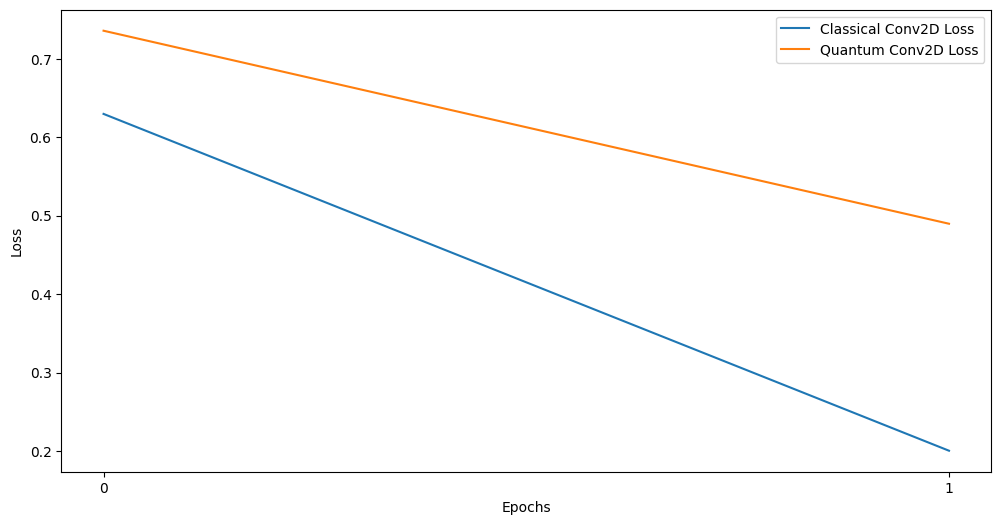

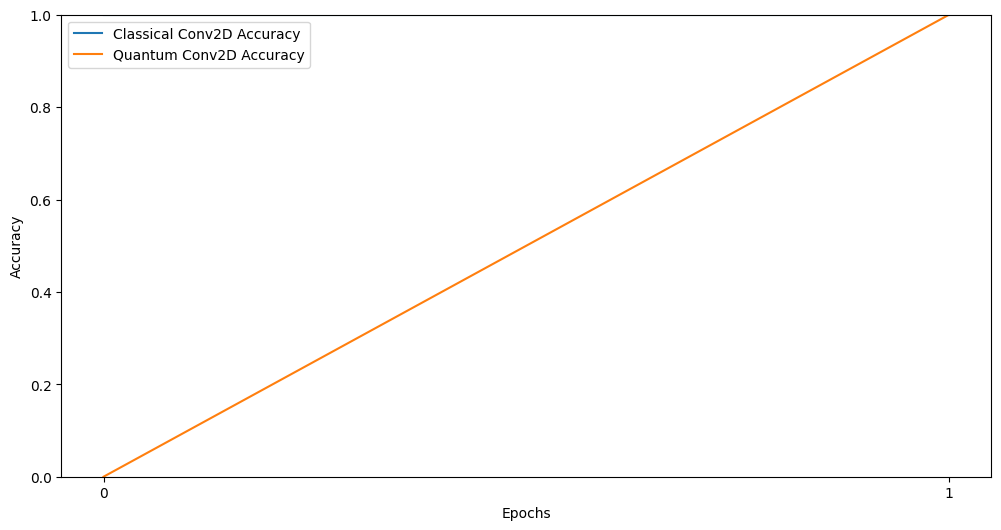

In [90]:
#plot accuracy and loss through epochs between classical and quantum model
plt.figure(figsize=(12, 6))
plt.plot(classical_conv2d_losses, label="Classical Conv2D Loss")
plt.plot(quantum_conv2d_losses, label="Quantum Conv2D Loss")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(classical_conv2d_accuracies, label="Classical Conv2D Accuracy")
plt.plot(quantum_conv2d_accuracies, label="Quantum Conv2D Accuracy")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()


### Fully connected

Define train and test function

In [91]:
def train(data_loader,model,loss_fn,optimizer):
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % number_of_conv2d_batch_size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(data_loader,model,loss_fn):
    size = len(data_loader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss


Load iris dataset

In [92]:
# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

#preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=dense_split_ratio, random_state=0)

#convert the data to torch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

train_dataloader = torch.utils.data.DataLoader(
    list(zip(X_train_tensor, y_train_tensor)), batch_size=number_of_dense_batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    list(zip(X_test_tensor, y_test_tensor)), batch_size=number_of_dense_batch_size, shuffle=True
)

torch.Size([120, 4])
torch.Size([120])
torch.Size([30, 4])
torch.Size([30])


Classical model

In [93]:
#initialize classical fully connected neural network
class ClassicalFullyConnected(nn.Module):
    def __init__(self):
        super(ClassicalFullyConnected,self).__init__()
        self.layer1 = nn.Linear(4,3)
        self.layer2 = nn.Linear(3,3)
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    
classical_fully_connected_model = ClassicalFullyConnected()
classical_fully_connected_loss_fn=nn.CrossEntropyLoss()
classical_fully_connected_optimizer=torch.optim.Adam(classical_fully_connected_model.parameters(),lr=0.01)

epochs = number_of_dense_epochs
classical_fully_connected_losses=[]
classical_fully_connected_accuracies=[]
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, classical_fully_connected_model, classical_fully_connected_loss_fn, classical_fully_connected_optimizer)
    correct,loss = test(test_dataloader, classical_fully_connected_model, classical_fully_connected_loss_fn)
    classical_fully_connected_losses.append(loss)
    classical_fully_connected_accuracies.append(correct)
end_time = time.time()
classical_fully_connected_time = end_time-start_time
print("Training Time: ", classical_fully_connected_time)

Epoch 1
-------------------------------
loss: 1.199376  [    0/  120]
loss: 1.345628  [    5/  120]
loss: 1.017483  [   10/  120]
loss: 0.881483  [   15/  120]
loss: 1.041122  [   20/  120]
loss: 1.127084  [   25/  120]
loss: 0.898823  [   30/  120]
loss: 1.218162  [   35/  120]
loss: 1.011144  [   40/  120]
loss: 0.827990  [   45/  120]
loss: 0.909976  [   50/  120]
loss: 0.798025  [   55/  120]
loss: 0.886069  [   60/  120]
loss: 0.801727  [   65/  120]
loss: 0.865814  [   70/  120]
loss: 0.750243  [   75/  120]
loss: 0.641704  [   80/  120]
loss: 0.656343  [   85/  120]
loss: 0.562035  [   90/  120]
loss: 0.597384  [   95/  120]
loss: 0.630536  [  100/  120]
loss: 0.673313  [  105/  120]
loss: 0.687838  [  110/  120]
loss: 0.624724  [  115/  120]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.108435 

Epoch 2
-------------------------------
loss: 0.578689  [    0/  120]
loss: 0.636311  [    5/  120]
loss: 0.344983  [   10/  120]
loss: 0.542162  [   15/  120]
loss: 0.494166  [   20/  120

Quantum model

In [94]:
#initialize quantum fully connected neural network
class QuantumFullyConnected(nn.Module):
    def __init__(self):
        super(QuantumFullyConnected,self).__init__()
        self.layer1 = QuantumLinear(4,3)
        self.layer2 = QuantumLinear(3,3)
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    
quantum_fully_connected_model = QuantumFullyConnected()
quantum_fully_connected_loss_fn=nn.CrossEntropyLoss()
quantum_fully_connected_optimizer=torch.optim.Adam(quantum_fully_connected_model.parameters(),lr=0.01)

epochs = number_of_dense_epochs
quantum_fully_connected_losses=[]
quantum_fully_connected_accuracies=[]
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, quantum_fully_connected_model, quantum_fully_connected_loss_fn, quantum_fully_connected_optimizer)
    correct,loss = test(test_dataloader, quantum_fully_connected_model, quantum_fully_connected_loss_fn)
    quantum_fully_connected_losses.append(loss)
    quantum_fully_connected_accuracies.append(correct)
end_time = time.time()
quantum_fully_connected_time = end_time-start_time
print("Training Time: ", quantum_fully_connected_time)

Epoch 1
-------------------------------
loss: 1.116874  [    0/  120]
loss: 1.082195  [    5/  120]
loss: 1.237486  [   10/  120]
loss: 1.193817  [   15/  120]
loss: 1.236765  [   20/  120]
loss: 0.980792  [   25/  120]
loss: 1.047589  [   30/  120]
loss: 1.299906  [   35/  120]
loss: 1.119706  [   40/  120]
loss: 1.246470  [   45/  120]
loss: 0.978029  [   50/  120]
loss: 1.144687  [   55/  120]
loss: 0.998556  [   60/  120]
loss: 1.025445  [   65/  120]
loss: 1.096635  [   70/  120]
loss: 1.101912  [   75/  120]
loss: 1.011600  [   80/  120]
loss: 0.885804  [   85/  120]
loss: 0.927491  [   90/  120]
loss: 1.112000  [   95/  120]
loss: 0.915337  [  100/  120]
loss: 0.958194  [  105/  120]
loss: 0.833147  [  110/  120]
loss: 0.978693  [  115/  120]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.164759 

Epoch 2
-------------------------------
loss: 0.813549  [    0/  120]
loss: 1.090500  [    5/  120]
loss: 0.791129  [   10/  120]
loss: 0.792778  [   15/  120]
loss: 0.797036  [   20/  120

Compare

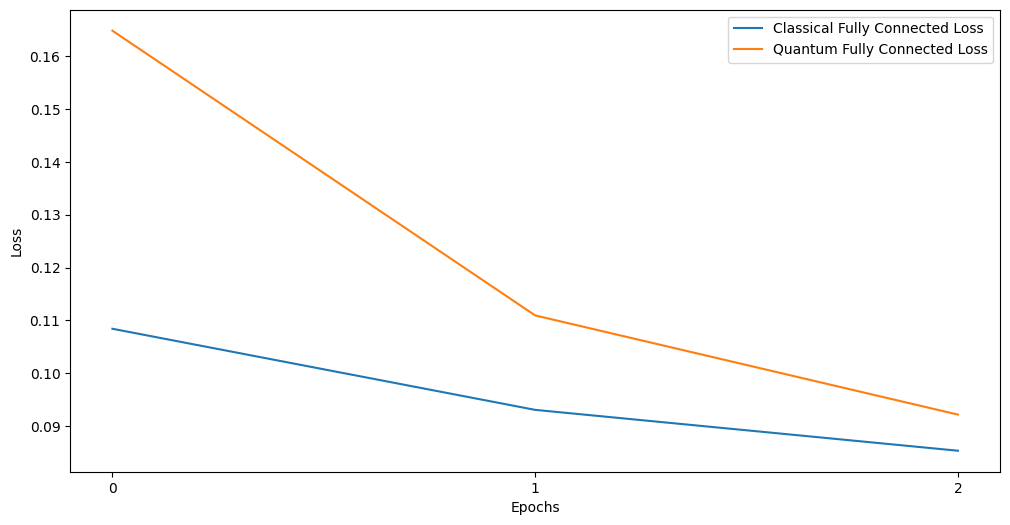

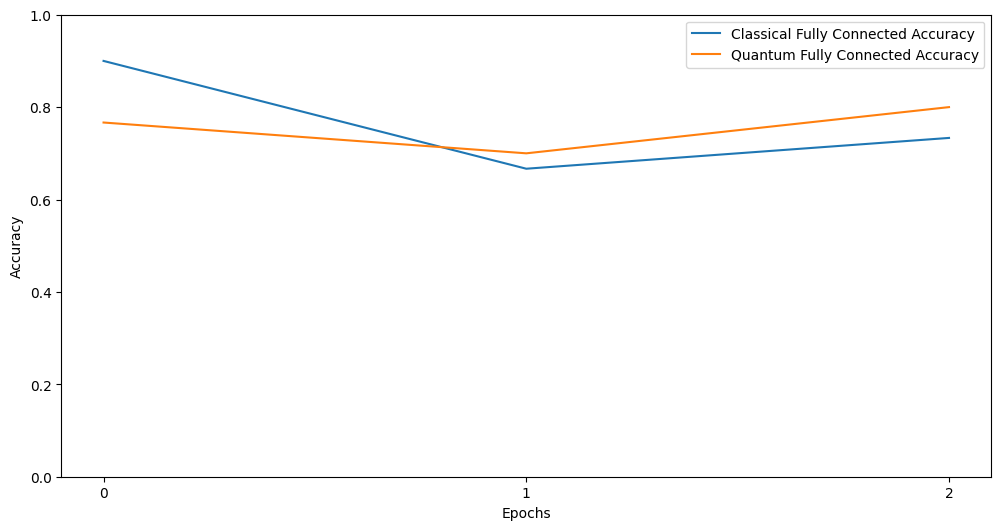

In [95]:
# Plot the accuracy and loss through epochs between classical and quantum model
plt.figure(figsize=(12, 6))
plt.plot(classical_fully_connected_losses, label="Classical Fully Connected Loss")
plt.plot(quantum_fully_connected_losses, label="Quantum Fully Connected Loss")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(classical_fully_connected_accuracies, label="Classical Fully Connected Accuracy")
plt.plot(quantum_fully_connected_accuracies, label="Quantum Fully Connected Accuracy")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()


### LSTM

Load and preprocess data

In [96]:
# Load the Penn Treebank dataset with universal tagset
corpus = treebank.tagged_sents(tagset='universal')

# Define the tags to keep
tags_to_keep = {'NOUN', 'ADJ', 'VERB'}

# Filter sentences to include only words with the specified tags
filtered_sentences = []
for sentence in corpus:
    filtered_sentence = [(word, tag) for word, tag in sentence if tag in tags_to_keep]
    if filtered_sentence:  
        filtered_sentences.append(filtered_sentence)


filtered_words = []
filtered_tags = []
for sentence in filtered_sentences:
    words, tags = zip(*sentence) 
    filtered_words.append(words)
    filtered_tags.append(tags)



tag_to_ix={'NOUN': 0, 'VERB': 1, 'ADJ': 2}
ix_to_tag={0: 'NOUN', 1: 'VERB', 2: 'ADJ'}
def prepare_sequence(seq, to_ix):
	idxs = [to_ix[w] for w in seq]
	return torch.tensor(idxs, dtype=torch.long)

training_data = list(zip(filtered_words, filtered_tags))
training_data = training_data[:number_of_lstm_samples]


formatted_training_data = []


for words, tags in training_data:
    formatted_training_data.append((list(words), list(tags)))
training_data = formatted_training_data

word_to_ix = {}
for sent, tags in training_data:
	for word in sent:
		if word not in word_to_ix:
			word_to_ix[word] = len(word_to_ix)
                  
print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")
embedding_dim = 8
hidden_dim = 6

Vocabulary: {'Pierre': 0, 'Vinken': 1, 'years': 2, 'old': 3, 'will': 4, 'join': 5, 'board': 6, 'nonexecutive': 7, 'director': 8, 'Nov.': 9, 'Mr.': 10, 'is': 11, 'chairman': 12, 'Elsevier': 13, 'N.V.': 14, 'Dutch': 15, 'publishing': 16, 'group': 17}
Entities: {0: 'NOUN', 1: 'VERB', 2: 'ADJ'}


Define train and test data

In [97]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

Classical LSTM Tagger

In [98]:
class LSTMTagger(nn.Module):
	def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
		super(LSTMTagger, self).__init__()
		self.hidden_dim = hidden_dim
		self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim)

		self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

	def forward(self, sentence):
		embeds = self.word_embeddings(sentence)
		lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
		tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
		tag_scores = F.log_softmax(tag_logits, dim=1)
		return tag_scores
	
n_epochs = number_of_lstm_epochs
classical_lstm_model = LSTMTagger(embedding_dim, 
						hidden_dim, 
						vocab_size=len(word_to_ix), 
						tagset_size=len(tag_to_ix))
start_time = time.time()
history_classical = train(classical_lstm_model, n_epochs)
end_time = time.time()
print_result(classical_lstm_model)
classical_lstm_time = end_time-start_time
print("Training Time: ", classical_lstm_time)
	

Epoch 1 / 2: Loss = 1.216 Acc = 0.16
Epoch 2 / 2: Loss = 1.152 Acc = 0.21
Sentence:  ['Pierre', 'Vinken', 'years', 'old', 'will', 'join', 'board', 'nonexecutive', 'director', 'Nov.']
Labels:    ['NOUN', 'NOUN', 'NOUN', 'ADJ', 'VERB', 'VERB', 'NOUN', 'ADJ', 'NOUN', 'NOUN']
Predicted: ['NOUN', 'VERB', 'VERB', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'VERB']
Training Time:  0.00951528549194336


Quantum LSTM Tagger

In [99]:
class LSTMTagger(nn.Module):
	def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=4):
		super(LSTMTagger, self).__init__()
		self.hidden_dim = hidden_dim
		self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
		self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
		self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

	def forward(self, sentence):
		embeds = self.word_embeddings(sentence)
		lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
		tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
		tag_scores = F.log_softmax(tag_logits, dim=1)
		return tag_scores
	
n_epochs = number_of_lstm_epochs
n_qubits = 4
model_quantum = LSTMTagger(embedding_dim,
						hidden_dim,
						vocab_size=len(word_to_ix),
						tagset_size=len(tag_to_ix),
						n_qubits=n_qubits)
start_time = time.time()
history_quantum = train(model_quantum, n_epochs)
end_time = time.time()
print_result(model_quantum)
quantum_lstm_time = end_time-start_time
print("Training Time: ", quantum_lstm_time)

weight_shapes = (number_of_quantum_layer, n_qubits) = (1, 4)
Epoch 1 / 2: Loss = 1.233 Acc = 0.11
Epoch 2 / 2: Loss = 1.172 Acc = 0.11
Sentence:  ['Pierre', 'Vinken', 'years', 'old', 'will', 'join', 'board', 'nonexecutive', 'director', 'Nov.']
Labels:    ['NOUN', 'NOUN', 'NOUN', 'ADJ', 'VERB', 'VERB', 'NOUN', 'ADJ', 'NOUN', 'NOUN']
Predicted: ['ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ', 'ADJ']
Training Time:  0.45377206802368164


Compare

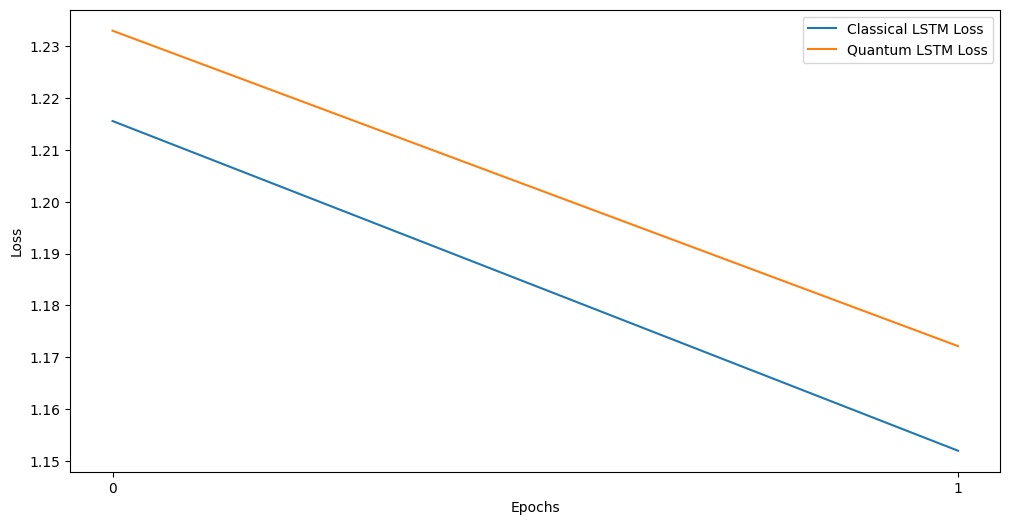

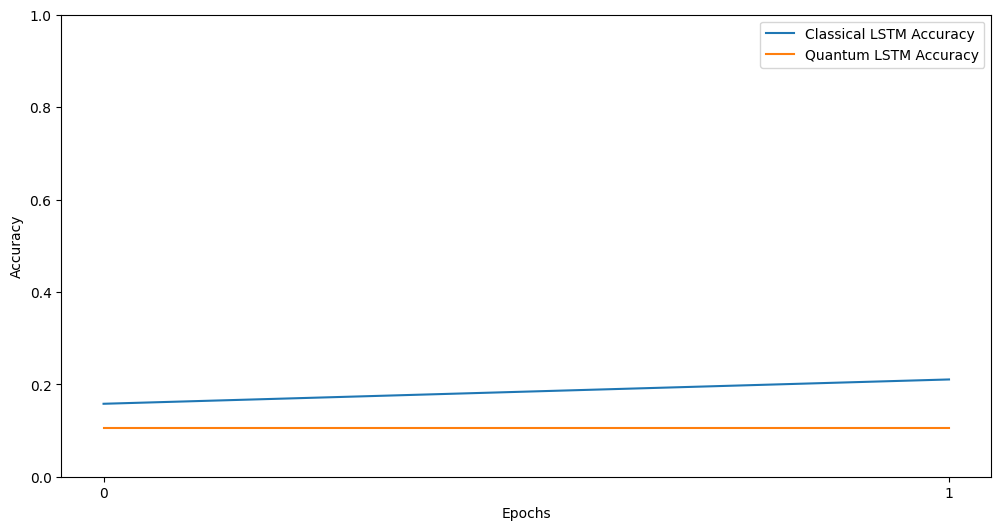

In [100]:
#plot the loss and accuracy through epochs between classical and quantum model
plt.figure(figsize=(12, 6))
plt.plot(history_classical['loss'], label="Classical LSTM Loss")
plt.plot(history_quantum['loss'], label="Quantum LSTM Loss")
plt.xlabel("Epochs")
plt.xticks(range(n_epochs))
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_classical['acc'], label="Classical LSTM Accuracy")
plt.plot(history_quantum['acc'], label="Quantum LSTM Accuracy")
plt.xlabel("Epochs")
plt.xticks(range(n_epochs))
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

# Transfer Learning

Define train and test function

In [101]:
def train(data_loader,model,loss_fn,optimizer):
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % number_of_conv2d_batch_size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(data_loader,model,loss_fn):
    size = len(data_loader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

Load 10x10 mnist dataset and preprocess data

In [109]:
# Load the MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



classes = [i for i in range(number_of_conv2d_classes, number_of_conv2d_classes+number_of_transfer_learning_classes)]

train_images = train_images[np.isin(train_labels, classes)]
train_labels = train_labels[np.isin(train_labels, classes)]
test_images = test_images[np.isin(test_labels, classes)]
test_labels = test_labels[np.isin(test_labels, classes)]
number_sample_train=int(number_of_conv2d_samples*(1-conv2d_split_ratio))
number_sample_test=number_of_conv2d_samples-number_sample_train

train_images = train_images[:number_sample_train]
test_images = test_images[:number_sample_test]
train_labels = train_labels[:number_sample_train]
test_labels = test_labels[:number_sample_test]

#align label
train_labels = train_labels-number_of_conv2d_classes
test_labels = test_labels-number_of_conv2d_classes


print(f"Train data shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
#convert (batch, height, width, channels) to (batch, channels, height, width)
train_images = np.transpose(train_images, (0,3,1,2))
test_images = np.transpose(test_images, (0,3,1,2))

#convert the data to torch tensors
X_train_tensor = torch.tensor(train_images).float()
y_train_tensor = torch.tensor(train_labels).long()
X_test_tensor = torch.tensor(test_images).float()
y_test_tensor = torch.tensor(test_labels).long()

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

mnist_train_dataloader = torch.utils.data.DataLoader(
    list(zip(X_train_tensor, y_train_tensor)), batch_size=number_of_transfer_learning_batch_size, shuffle=True
)

mnist_test_dataloader = torch.utils.data.DataLoader(
    list(zip(X_test_tensor, y_test_tensor)), batch_size=number_of_transfer_learning_batch_size, shuffle=True
)

Train data shape: (3, 28, 28)
Train labels shape: (3,)
Test data shape: (1, 28, 28)
Test labels shape: (1,)
torch.Size([3, 1, 28, 28])
torch.Size([3])
torch.Size([1, 1, 28, 28])
torch.Size([1])


Create qconv2d model to train with 2 classes and calculate time

In [113]:
quantum_conv2d_model_without_transfer_learning = QuantumConv2DNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(quantum_conv2d_model_without_transfer_learning.parameters(), lr=1e-3)

epochs = number_of_transfer_learning_epochs

quantum_conv2d_losses_without_transfer_learning=[]
quantum_conv2d_accuracies_without_transfer_learning=[]
start_time = time.time()
for t in range(epochs):
	print(f"Epoch {t+1}\n-------------------------------")
	train(mnist_train_dataloader, quantum_conv2d_model_without_transfer_learning, loss_fn, optimizer)
	correct,loss = test(mnist_test_dataloader, quantum_conv2d_model_without_transfer_learning, loss_fn)
	quantum_conv2d_losses_without_transfer_learning.append(loss)
	quantum_conv2d_accuracies_without_transfer_learning.append(correct)
end_time = time.time()

quantum_conv2d_time_without_transfer_learning = end_time-start_time
print("Training Time: ", quantum_conv2d_time_without_transfer_learning)



Epoch 1
-------------------------------
loss: 0.735175  [    0/    3]
loss: 0.697130  [    1/    3]
loss: 5.598698  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.431526 

Epoch 2
-------------------------------
loss: 0.350487  [    0/    3]
loss: 0.756959  [    1/    3]
loss: 0.487662  [    2/    3]
Test Error: 
 Accuracy: 0.0%, Avg loss: 1.811769 

Training Time:  93.00502133369446


Use quantum_conv2d_model above 

In [121]:
# Save only the state dictionary of the model
torch.save(quantum_conv2d_model.state_dict(), 'quantum_conv2d_model.pth')

# Load the model architecture and initialize its weights
quantum_conv1d_model_transfer_learning = QuantumConv2DNetwork()

# Load the state dictionary into the initialized model
quantum_conv1d_model_transfer_learning.load_state_dict(torch.load('quantum_conv2d_model.pth'))

#train the last layer of the model
for param in quantum_conv1d_model_transfer_learning.parameters():
	param.requires_grad = False
quantum_conv1d_model_transfer_learning.fc2.weight.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(quantum_conv1d_model_transfer_learning.parameters(), lr=1e-3)

epochs = number_of_transfer_learning_epochs

quantum_conv2d_losses_transfer_learning=[]
quantum_conv2d_accuracies_transfer_learning=[]

start_time = time.time()
for t in range(epochs):
	print(f"Epoch {t+1}\n-------------------------------")
	train(mnist_train_dataloader, quantum_conv1d_model_transfer_learning, loss_fn, optimizer)
	correct,loss = test(mnist_test_dataloader, quantum_conv1d_model_transfer_learning, loss_fn)
	quantum_conv2d_losses_transfer_learning.append(loss)
	quantum_conv2d_accuracies_transfer_learning.append(correct)
end_time = time.time()

quantum_conv2d_time_transfer_learning = end_time-start_time
print("Training Time: ", quantum_conv2d_time_transfer_learning)

Epoch 1
-------------------------------
loss: 0.082473  [    0/    3]
loss: 0.310377  [    1/    3]
loss: 1.706368  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.448983 

Epoch 2
-------------------------------
loss: 0.506805  [    0/    3]
loss: 0.136405  [    1/    3]
loss: 2.112479  [    2/    3]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.312794 

Training Time:  87.12531781196594


Compare between two models

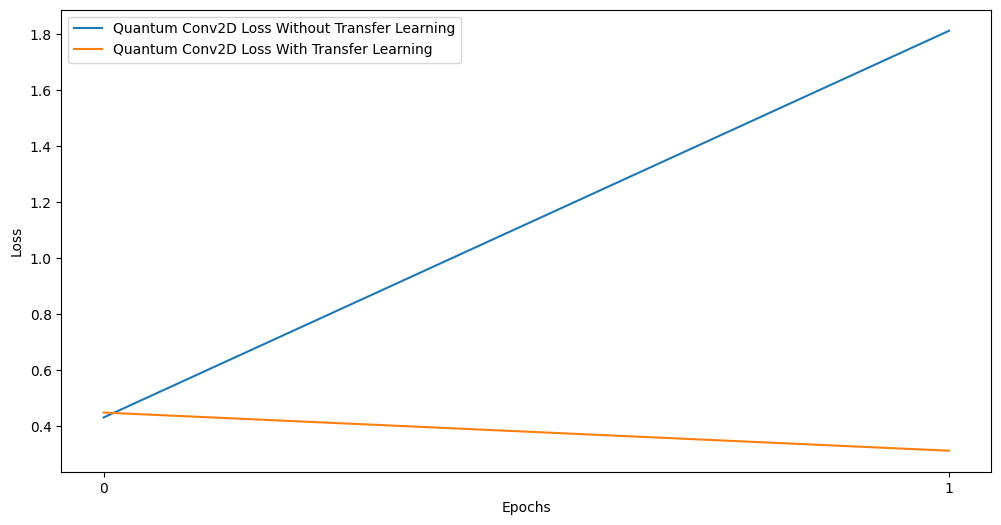

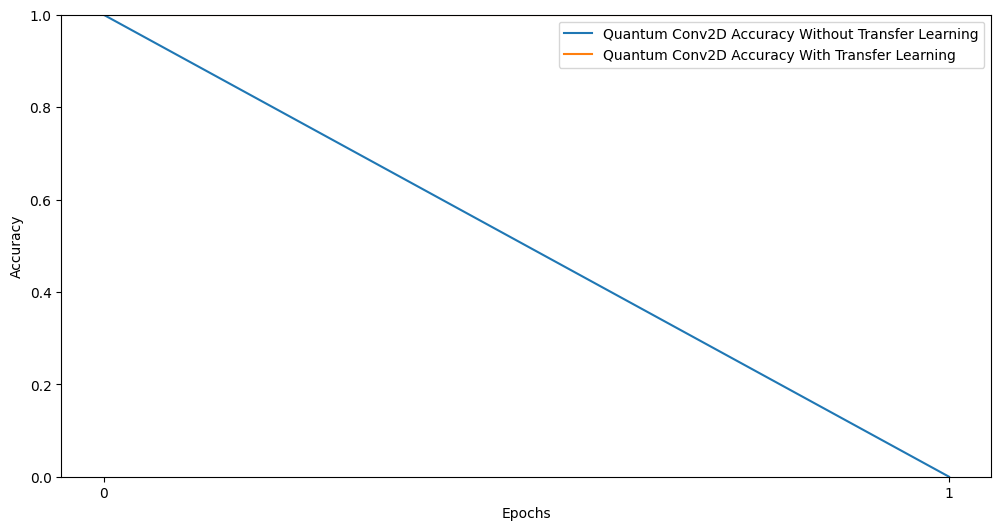

In [122]:
#plot accuracy and loss through epochs between quantum model and transfer model
plt.figure(figsize=(12, 6))
plt.plot(quantum_conv2d_losses_without_transfer_learning, label="Quantum Conv2D Loss Without Transfer Learning")
plt.plot(quantum_conv2d_losses_transfer_learning, label="Quantum Conv2D Loss With Transfer Learning")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(quantum_conv2d_accuracies_without_transfer_learning, label="Quantum Conv2D Accuracy Without Transfer Learning")
plt.plot(quantum_conv2d_accuracies_transfer_learning, label="Quantum Conv2D Accuracy With Transfer Learning")
plt.xlabel("Epochs")
plt.xticks(range(epochs))
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

In [123]:
#print time of all models
print("Conv1D Classical Time: ", classical_conv1d_time)
print("Conv1D Quantum Time: ", quantum_conv1d_time)
print("Conv2D Classical Time: ", classical_conv2d_time)
print("Conv2D Quantum Time: ", quantum_conv2d_time)
print("Dense Classical Time: ", classical_fully_connected_time)
print("Dense Quantum Time: ", quantum_fully_connected_time)
print("LSTM Classical Time: ", classical_lstm_time)
print("LSTM Quantum Time: ", quantum_lstm_time)
print("Transfer Learning Quantum Time Without Transfer Learning: ", quantum_conv2d_time_without_transfer_learning)
print("Transfer Learning Quantum Time With Transfer Learning: ", quantum_conv2d_time_transfer_learning)

Conv1D Classical Time:  0.03261566162109375
Conv1D Quantum Time:  6.715039491653442
Conv2D Classical Time:  0.01701498031616211
Conv2D Quantum Time:  96.8149938583374
Dense Classical Time:  0.12088489532470703
Dense Quantum Time:  4.3234899044036865
LSTM Classical Time:  0.00951528549194336
LSTM Quantum Time:  0.45377206802368164
Transfer Learning Quantum Time Without Transfer Learning:  93.00502133369446
Transfer Learning Quantum Time With Transfer Learning:  87.12531781196594


# Quantization

Load 10x10 MNIST dataset and preprocess data

In [126]:
# Load the MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



classes = [i for i in range(number_of_quantization_classes)]

train_images = train_images[np.isin(train_labels, classes)]
train_labels = train_labels[np.isin(train_labels, classes)]
test_images = test_images[np.isin(test_labels, classes)]
test_labels = test_labels[np.isin(test_labels, classes)]
number_sample_train=int(number_of_conv2d_samples*(1-conv2d_split_ratio))
number_sample_test=number_of_conv2d_samples-number_sample_train

train_images = train_images[:number_sample_train]
test_images = test_images[:number_sample_test]
train_labels = train_labels[:number_sample_train]
test_labels = test_labels[:number_sample_test]


print(f"Train data shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
#convert (batch, height, width, channels) to (batch, channels, height, width)
train_images = np.transpose(train_images, (0,3,1,2))
test_images = np.transpose(test_images, (0,3,1,2))

#convert the data to torch tensors
X_train_tensor = torch.tensor(train_images).float()
y_train_tensor = torch.tensor(train_labels).long()
X_test_tensor = torch.tensor(test_images).float()
y_test_tensor = torch.tensor(test_labels).long()

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

mnist_train_dataloader = torch.utils.data.DataLoader(
    list(zip(X_train_tensor, y_train_tensor)), batch_size=number_of_quantization_batch_size, shuffle=True
)

mnist_test_dataloader = torch.utils.data.DataLoader(
    list(zip(X_test_tensor, y_test_tensor)), batch_size=number_of_quantization_batch_size, shuffle=True
)

Train data shape: (3, 28, 28)
Train labels shape: (3,)
Test data shape: (1, 28, 28)
Test labels shape: (1,)
torch.Size([3, 1, 28, 28])
torch.Size([3])
torch.Size([1, 1, 28, 28])
torch.Size([1])


Quantization Function

In [169]:
# Function to quantize the weights
def quantize_weights(input_file, output_file, quantize_level):
    with open(input_file, 'r') as f:
        lines = f.readlines()
    
    # Initialize min and max values
    min_val = float('inf')
    max_val = float('-inf')
    
    # Find the minimum and maximum values in the file
    for line in lines:
        line = line.strip()
        if ':' in line or line == '':
            continue
        else:
            weights = np.fromstring(line, sep=' ')
            min_val = min(min_val, weights.min())
            max_val = max(max_val, weights.max())
    
    # Define quantization scale
    quantize_scale = (max_val - min_val) / (2 ** quantize_level)
    
    with open(output_file, 'w') as f_out:
        f_out.write(f"{min_val} {max_val} {quantize_level}\n")
        for line in lines:
            line = line.strip()
            if ':' in line:
                f_out.write(line + '\n')
            else:
                # Quantize the weights
                weights = np.fromstring(line, sep=' ')
                quantized_weights = np.round((weights - min_val) / quantize_scale).astype(np.int8)
                np.savetxt(f_out, quantized_weights.reshape(1, -1), fmt='%d')

# Function to dequantize the weights
def dequantize_weights(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()
    min_val, max_val, quantize_level = map(float, lines[0].split())
    quantize_scale = (max_val - min_val) / (2 ** quantize_level)
    with open(output_file, 'w') as f_out:
        for line in lines[1:]:
            line = line.strip()
            if ':' in line:
                f_out.write(line + '\n')
            else:
                quantized_weights = np.fromstring(line, sep=' ')
                weights = quantized_weights * quantize_scale + min_val
                np.savetxt(f_out, weights.reshape(1, -1), fmt='%f')

def recreate_model_from_weights(weight_file, model_class):
    # Initialize an empty model with the same architecture as the original model
    model = model_class()  
    
    # Load the weights from the text file
    with open(weight_file, 'r') as f:
        lines = f.readlines()
    
    # Iterate through the lines to extract layer names and weights
    layer_name = None
    weights = []
    for line in lines:
        line = line.strip()
        if ':' in line:
            # If a layer name is encountered, set the weights for the previous layer (if any)
            if layer_name is not None:
                layer = getattr(model, layer_name, None)
                if layer is not None and hasattr(layer, 'weight'):
                    layer.weight.data = torch.tensor(np.array(weights))
            # Update the layer name and reset the weights list
            layer_name = line[:-1]  # Remove the colon at the end
            weights = []
        else:
            # Parse the weight values and append them to the weights list
            weight_values = np.fromstring(line, dtype=float, sep=' ')
            weights.append(weight_values)
    
    # Set the weights for the last layer
    if layer_name is not None:
        layer = getattr(model, layer_name, None)
        if layer is not None and hasattr(layer, 'weight'):
            layer.weight.data = torch.tensor(np.array(weights))
    
    return model


Quantize model

In [170]:
# Load the original model
original_model = QuantumConv2DNetwork()
original_model.load_state_dict(torch.load('quantum_conv2d_model.pth'))

# Save the original model weights to a text file
with open('fp32_weights.txt', 'w') as f:
    for name, param in original_model.state_dict().items():
        param_data = param.cpu().numpy().flatten()
        f.write(f"{name}:\n")
        np.savetxt(f, param_data, fmt='%f')
        f.write('\n')

# Example usage:
input_file = 'fp32_weights.txt'
output_file = 'qint8_weights.txt'
quantize_level = 8  # Specify the number of bits for quantization
quantize_weights(input_file, output_file, quantize_level)

input_file = 'qint8_weights.txt'
output_file = 'deqint8_weights.txt'
dequantize_weights(input_file, output_file)


# Example usage:
weight_file = 'deqint8_weights.txt'
quantized_model = recreate_model_from_weights(weight_file, QuantumConv2DNetwork)


Compare accuracy,time and size of original model and quantized model

In [171]:
#evaluate the model and quantized model accuracy
loss_fn = nn.CrossEntropyLoss()
original_model = QuantumConv2DNetwork()
original_model.load_state_dict(torch.load('quantum_conv2d_model.pth'))
original_model.eval()
start_time = time.time()
original_val= test(mnist_test_dataloader, original_model, loss_fn)
end_time = time.time()
original_time = end_time-start_time


quantized_model = QuantumConv2DNetwork()
quantized_model.load_state_dict(torch.load('quantized_quantum_conv2d_model.pth'))
quantized_model.eval()
start_time = time.time()
quantized_val = test(mnist_test_dataloader, quantized_model, loss_fn)
end_time = time.time()
quantized_time = end_time-start_time

print(f"Original model accuracy: {original_val[0]*100:.2f}%")
print(f"Quantized model accuracy: {quantized_val[0]*100:.2f}%")
print(f"Original model inference time: {original_time:.2f} seconds")
print(f"Quantized model inference time: {quantized_time:.2f} seconds")

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.860396 

Test Error: 
 Accuracy: 0.0%, Avg loss: 3053696.000000 

Original model accuracy: 0.00%
Quantized model accuracy: 0.00%
Original model inference time: 8.32 seconds
Quantized model inference time: 8.13 seconds


In [177]:
# print size of the original model and the quantized model
original_model_size = os.path.getsize('fp32_weights.txt')
quantized_model_size = os.path.getsize('qint8_weights.txt')

print(f"Original model size: {original_model_size} bytes")
print(f"Quantized model size: {quantized_model_size} bytes")

Original model size: 535517 bytes
Quantized model size: 204153 bytes
